In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [34]:
from collections import defaultdict

import mat73
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datasets
import transformers
import torch

## Prep

In [3]:
model_name = "facebook/wav2vec2-base"
dataset_path = "data/timit_phoneme"

In [4]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
model = transformers.Wav2Vec2Model.from_pretrained(model_name)
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:792: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enabl

In [5]:
dataset = datasets.load_from_disk(dataset_path)

### Load TIMIT annotations

In [6]:
annot_sent_names = mat73.loadmat("data/timit_annotations/sent_names.mat")["sent_names"]
annot_data = mat73.loadmat("data/timit_annotations/TIMIT_ecog_info.mat")["sentdet"]["sentdet"]

In [7]:
assert len(annot_sent_names) == len(annot_data)

In [8]:
annot_sent_df = pd.DataFrame({"sent_name": annot_sent_names})
annot_sent_df[["speaker_conj", "sentence"]] = annot_sent_df["sent_name"].str.upper().str.split("_", expand=True)
annot_sent_df["speaker_id"] = annot_sent_df.speaker_conj.str[1:]
annot_sent_df = annot_sent_df.drop(columns=["sent_name", "speaker_conj"])
annot_sent_df

,sentence,speaker_id
0,SI1279,ADG0
1,SI2022,AEM0
2,SI1955,ALR0
3,SI1000,AWF0
4,SI1612,BCG1
...,...,...
494,SI1687,WRE0
495,SI2317,WRE0
496,SI1525,WRP0
497,SI2256,WSB0


#### Check for overlap with dataset

In [9]:
dataset_sent_df = pd.concat([
    pd.DataFrame({"sentence": dataset["train"]["id"], "speaker_id": dataset["train"]["speaker_id"]}),
    pd.DataFrame({"sentence": dataset["test"]["id"], "speaker_id": dataset["test"]["speaker_id"]}),
], names=["dataset"], keys=["train", "test"])
dataset_sent_df

sentence speaker_id
dataset                         
train   0         SA1       CJF0
        1         SA2       CJF0
        2      SI1027       CJF0
        3      SI1657       CJF0
        4       SI648       CJF0
...               ...        ...
test    1675    SX113       SLB0
        1676    SX203       SLB0
        1677     SX23       SLB0
        1678    SX293       SLB0
        1679    SX383       SLB0

[6300 rows x 2 columns]

In [10]:
merged_df = pd.merge(annot_sent_df, dataset_sent_df.reset_index(), on=["sentence", "speaker_id"], how="inner",
                     validate="one_to_one").drop(columns=["level_1"])
merged_df

,sentence,speaker_id,dataset
0,SI1279,ADG0,test
1,SI2022,AEM0,train
2,SI1955,ALR0,train
3,SI1000,AWF0,test
4,SI1612,BCG1,train
...,...,...,...
494,SI1687,WRE0,train
495,SI2317,WRE0,train
496,SI1525,WRP0,train
497,SI2256,WSB0,train


In [11]:
merged_df.dataset.value_counts()

dataset
train    374
test     125
Name: count, dtype: int64

### Visualize one

In [12]:
viz_idx = np.random.choice(len(merged_df))
viz_row = merged_df.iloc[viz_idx]
print(viz_row)

sentence      SI1925
speaker_id      DWH0
dataset        train
Name: 237, dtype: object


In [13]:
viz_item_idx = np.where((np.array(dataset[viz_row.dataset]["id"]) == viz_row.sentence) & (np.array(dataset[viz_row.dataset]["speaker_id"]) == viz_row.speaker_id))[0].item()
viz_item = dataset[viz_row.dataset][viz_item_idx]

In [15]:
viz_annot = annot_data[viz_idx]
viz_annot.keys()

dict_keys(['EC129', 'EC131', 'EC133', 'EC137', 'EC142', 'EC156', 'F13P', 'F1Trans', 'F23P', 'F2Trans', 'aud', 'befaft', 'cycleDur', 'cycleId', 'dataf', 'duration', 'envmin', 'envminLog', 'formants', 'frmMedOns', 'loudness', 'loudnessExtLoc', 'loudnessExtVal', 'loudnessRelExtLoc', 'loudnessSentOns', 'loudness_delta', 'loudness_old', 'loudnessall', 'loudnessallNames', 'loudnesscyclePeakPhn', 'loudnessfrmMedVal', 'loudnesssentIdlong', 'name', 'onsOff', 'phnfeat', 'phnfeatNames', 'phnfeatonset', 'phnmat', 'phnmatonset', 'sentId', 'sentIdlong', 'sentence_onset', 'sound', 'soundOns', 'soundf', 'stress', 'sylOns', 'syllableNumber', 'syltype', 'vowel', 'vowelTimes', 'wrdOns'])

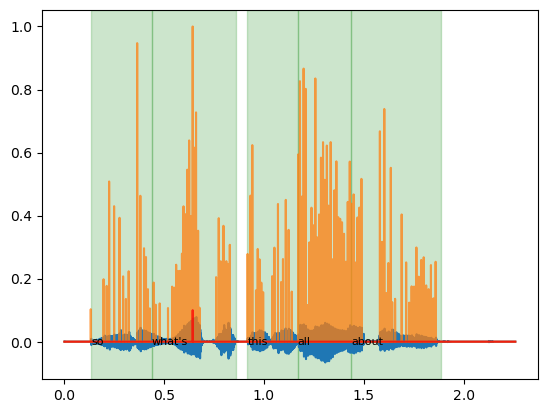

In [16]:
def calc_peak_rate(audio):
    import scipy.signal
    from scipy.signal import hilbert
    n_samples = audio.shape[0]
    env = np.abs(hilbert(audio))[:n_samples]
    b, a = scipy.signal.butter(3, 0.01)
    env = scipy.signal.filtfilt(b, a, env)

    # normalize envelope to between -1 and 1
    env_norm = env/np.max(np.abs(env))

    # discrete loudness (peak env)
    peak_idx, props = scipy.signal.find_peaks(env_norm, height=0.1)
    peakEnv = np.zeros(len(env_norm))
    peakEnv[peak_idx] = props['peak_heights'] 

    # max envelope
    maxEnv = np.zeros(len(env_norm))
    maxEnv[peak_idx[np.nanargmax(props['peak_heights'])]] = 1

    # first temporal derivative of TS
    diff_loudness = np.diff(env_norm)

    # discrete delta loudness (peak rate)
    diff_loudness[diff_loudness<0] = 0
    diff_loudness = diff_loudness / np.max(diff_loudness)
    # SJ: Stores the derivative of pitch at timepoints where
    # the pitch rose ("delta upwards") and by more than 10%
    # (since its normed to 0-1)
    peak_idx, props = scipy.signal.find_peaks(diff_loudness, height=0.1)
    peakRate = np.zeros(len(diff_loudness))
    peakRate[peak_idx] = props['peak_heights']

    # loudest moment peakrate
    maxRate = np.zeros(len(diff_loudness))
    maxRate[peak_idx[np.nanargmax(props['peak_heights'])]] = 1

    return peakRate, maxRate

# duration = viz_item["audio"]["array"].shape[0] / 16000
# ts = np.arange(0, duration, step=1/100)
# audio_resamp = np.interp(ts, np.arange(0, duration, step=1/16000), viz_item["audio"]["array"])
audio_resamp = viz_item["audio"]["array"]
peak_rates, max_rates = calc_peak_rate(audio_resamp)#viz_item["audio"]["array"])
# ts = np.arange(peak_rates.shape[0]) / 100
ts = np.arange(peak_rates.shape[0]) / 16000
plt.plot(ts, audio_resamp[:len(peak_rates)])
plt.plot(ts, peak_rates / 1, alpha=0.75)
plt.plot(ts, max_rates / 10, alpha=0.75, color="red")

for start, stop, word in zip(viz_item["word_detail"]["start"], viz_item["word_detail"]["stop"], viz_item["word_detail"]["utterance"]):
    plt.axvspan(start / 16000, stop / 16000, alpha=0.2, color="green")
    plt.text(start / 16000, 0, word, fontsize=8, ha="left", va="center")

In [17]:
viz_item.keys()

dict_keys(['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets'])

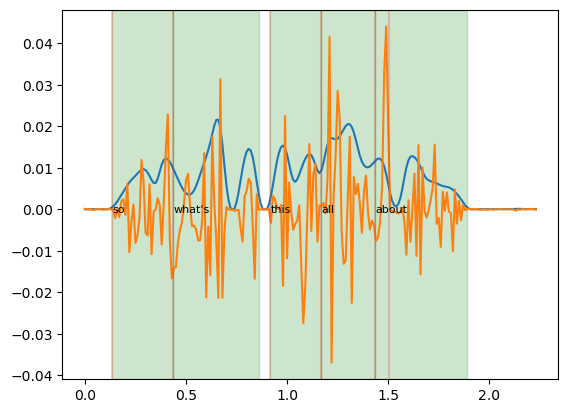

In [20]:
# ts = np.arange(viz_annot["formants"].shape[1]) / 100
# plt.plot(ts, viz_annot["formants"][0] / 10000)

key = "phnfeat"  # over span of phone; use "phnfeatonset" for just phone onset
key = "stress"
key = "envmin"
viz_annot_data = viz_annot[key]
# Remove padding
padding_samples = int(0.5 * viz_annot["dataf"])
viz_annot_data = viz_annot_data[padding_samples:-padding_samples]
# viz_annot_data = viz_annot["phnfeatonset"][4]
num_samples = viz_annot_data.shape[-1]
ts = np.arange(num_samples) / viz_annot["dataf"]
plt.plot(ts, viz_annot_data / 10)

viz_audio = viz_item["audio"]["array"]
audio_resamp = np.interp(ts, np.arange(len(viz_audio)) / 16000, viz_audio)
plt.plot(ts, audio_resamp)

for start, stop, word in zip(viz_item["word_detail"]["start"], viz_item["word_detail"]["stop"], viz_item["word_detail"]["utterance"]):
    plt.axvspan(start / 16000, stop / 16000, alpha=0.2, color="green")
    plt.text(start / 16000, 0, word, fontsize=8, ha="left", va="center")

onset_feature = "sylOns"
for onset_time in viz_annot[onset_feature]:
    plt.axvline(onset_time, alpha=0.2, color="red")

## Run evaluation

In [21]:
eval_idxs = set(merged_df[["sentence", "speaker_id"]].to_records(index=False).tolist())
eval_idxs

{('SI1000', 'AWF0'),
 ('SI1001', 'JBR0'),
 ('SI1008', 'RAV0'),
 ('SI1026', 'LAS0'),
 ('SI1028', 'JMD0'),
 ('SI1029', 'PAM1'),
 ('SI1030', 'REW0'),
 ('SI1033', 'JFC0'),
 ('SI1034', 'PEB0'),
 ('SI1049', 'SAH1'),
 ('SI1066', 'DKS0'),
 ('SI1067', 'PSW0'),
 ('SI1070', 'LTM0'),
 ('SI1074', 'AJP0'),
 ('SI1083', 'CMM0'),
 ('SI1089', 'MWH0'),
 ('SI1092', 'CRC0'),
 ('SI1095', 'RJM0'),
 ('SI1111', 'CKE0'),
 ('SI1114', 'JRF0'),
 ('SI1116', 'JRE0'),
 ('SI1119', 'HMR0'),
 ('SI1125', 'JRH0'),
 ('SI1143', 'JWS0'),
 ('SI1144', 'CTT0'),
 ('SI1148', 'ETB0'),
 ('SI1159', 'VKB0'),
 ('SI1161', 'JDC0'),
 ('SI1167', 'RDS0'),
 ('SI1169', 'BML0'),
 ('SI1171', 'SJS0'),
 ('SI1174', 'DRB0'),
 ('SI1179', 'GJD0'),
 ('SI1185', 'KXL0'),
 ('SI1188', 'ARC0'),
 ('SI1191', 'JPG0'),
 ('SI1192', 'TJS0'),
 ('SI1193', 'SLB0'),
 ('SI1199', 'RGG0'),
 ('SI1200', 'DTB0'),
 ('SI1205', 'PRB0'),
 ('SI1213', 'KLT0'),
 ('SI1218', 'DMS0'),
 ('SI1223', 'RCS0'),
 ('SI1224', 'RAB0'),
 ('SI1238', 'DMA0'),
 ('SI1243', 'LMA0'),
 ('SI1245', '

In [22]:
train_ds_idxs = [idx for idx, (sentence, speaker_id) in enumerate(zip(dataset["train"]["id"], dataset["train"]["speaker_id"]))
                if (sentence, speaker_id) in eval_idxs]
test_ds_idxs = [idx for idx, (sentence, speaker_id) in enumerate(zip(dataset["test"]["id"], dataset["test"]["speaker_id"]))
               if (sentence, speaker_id) in eval_idxs]
eval_dataset = datasets.concatenate_datasets([dataset["train"].select(train_ds_idxs), dataset["test"].select(test_ds_idxs)])

In [23]:
def add_hidden_state(item):
    with torch.no_grad():
        hidden_states = model(torch.tensor(item["input_values"]).unsqueeze(0), output_hidden_states=True).hidden_states
        for i, hidden_i in enumerate(hidden_states):
            item[f"hidden_state_{i}"] = hidden_i.squeeze(0)
    return item
eval_dataset = eval_dataset.map(add_hidden_state, batched=False)

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

In [28]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm.auto import tqdm, trange

In [29]:
# Prepare target labels
def prepare_target_labels(item, idx, padding_time=0.5):
    annot_item = annot_data[idx]

    phn_feat_names = [x[0] for x in annot_item["phnfeatNames"]]

    for idx, phn_feat_name in enumerate(phn_feat_names):
        phn_feat = annot_item["phnfeat"][idx]

        # Remove padding
        padding_samples = int(padding_time * annot_item["dataf"])
        phn_feat = phn_feat[padding_samples:-padding_samples]

        # Resample to match hidden state
        duration = len(item["input_values"]) / 16000
        num_samples = len(item["hidden_state_0"])
        phn_feat = np.interp(np.linspace(0, duration, num_samples),
                             np.arange(phn_feat.shape[0]) / annot_item["dataf"],
                             phn_feat)
        assert len(item["hidden_state_0"]) == phn_feat.shape[0]

        item[f"phn_feat_{phn_feat_name}"] = phn_feat

    return item

eval_dataset = eval_dataset.map(prepare_target_labels, with_indices=True)

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

In [366]:
classifiers = {}
classifier_scores = {}

In [367]:
eval_layers = list(range(13))
eval_features = [x[0] for x in annot_data[0]["phnfeatNames"]]
n_components = 32

import itertools
import pickle
for eval_layer, eval_feature in tqdm(list(itertools.product(eval_layers, eval_features))):
    if (eval_layer, eval_feature) in classifiers:
        continue
    X = np.concatenate([np.array(state) for state in eval_dataset[f"hidden_state_{eval_layer}"]])
    y = np.concatenate([np.array(phn_feat) for phn_feat in eval_dataset[f"phn_feat_{eval_feature}"]])
    if y.sum() == 0:
        print("No valid labels for", eval_layer, eval_feature)
        continue
    assert X.shape[0] == y.shape[0]

    # Convert to binary features
    y = (y > 0).astype(int)
    X_pca = PCA(n_components=n_components).fit_transform((X - X.mean(axis=0)) / X.std(axis=0))

    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, y, stratify=y, test_size=0.2, random_state=42)

    lr_model = LogisticRegressionCV(cv=StratifiedKFold(4, shuffle=True),
                                    scoring="roc_auc", class_weight="balanced",
                                    random_state=42)
    lr_model.fit(X_train, y_train)

    classifiers[eval_layer, eval_feature] = lr_model
    classifier_scores[eval_layer, eval_feature] = precision_recall_fscore_support(y_test, lr_model.predict(X_test), average="binary")

    with open("classifiers.pkl", "wb") as f:
        pickle.dump({"classifiers": classifiers, "scores": classifier_scores}, f)

  0%|          | 0/195 [00:00<?, ?it/s]

No valid labels for 0 names
No valid labels for 1 names
No valid labels for 2 names
No valid labels for 3 names
No valid labels for 4 names
No valid labels for 5 names
No valid labels for 6 names
No valid labels for 7 names
No valid labels for 8 names
No valid labels for 9 names
No valid labels for 10 names
No valid labels for 11 names
No valid labels for 12 names


## Feature selectivity index

Estimate on TIMIT since we don't have the diphone audio stimuli at the moment

In [50]:
feature_names = [x[0] for x in annot_data[0]["phnfeatNames"] if x[0] != "names"]
feature_eval_layers = list(range(13))

# First characterize the response of each hidden unit to each feature
# as the mean activation of the hidden unit over a 0-60ms time window
# with the onset of the feature.
feature_responses = defaultdict(list)
feature_response_window = 0.06
feature_agg_fn = np.mean

def add_feature_responses(item, eval_layers=None, model_sfreq=50):
    if eval_layers is None:
        eval_layers = feature_eval_layers[:]

    for feature in feature_names:
        # Resampling may have made some values fractional -- fix that
        feature_values = np.array(item[f"phn_feat_{feature}"])
        feature_values = (feature_values > 0).astype(int)
        # Now convert span representation to onset representation
        feature_onsets = (feature_values - np.roll(feature_values, 1)) == 1
        feature_onset_samples = np.where(feature_onsets)[0]

        for layer in eval_layers:
            hidden_state = np.array(item[f"hidden_state_{layer}"])

            for sample in feature_onset_samples:
                start_idx = sample
                end_idx = min(hidden_state.shape[0], int(sample + feature_response_window * model_sfreq))
                feature_response = feature_agg_fn(hidden_state[start_idx:end_idx], axis=0)
                feature_responses[layer, feature].append(feature_response)

eval_dataset.map(add_feature_responses, fn_kwargs={"eval_layers": feature_eval_layers})

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'hidden_state_0', 'hidden_state_1', 'hidden_state_2', 'hidden_state_3', 'hidden_state_4', 'hidden_state_5', 'hidden_state_6', 'hidden_state_7', 'hidden_state_8', 'hidden_state_9', 'hidden_state_10', 'hidden_state_11', 'hidden_state_12', 'phn_feat_dorsal', 'phn_feat_coronal', 'phn_feat_labial', 'phn_feat_high', 'phn_feat_front', 'phn_feat_low', 'phn_feat_back', 'phn_feat_plosive', 'phn_feat_fricative', 'phn_feat_syllabic', 'phn_feat_nasal', 'phn_feat_voiced', 'phn_feat_obstruent', 'phn_feat_sonorant', 'phn_feat_names'],
    num_rows: 499
})

In [108]:
# feature_responses_mat: num_layers * hidden_size * num_features
feature_responses_mat = np.array([[np.array(feature_responses[layer, feature]).mean(axis=0)
                                   for feature in feature_names]
                                  for layer in feature_eval_layers])
feature_responses_mat = feature_responses_mat.transpose(0, 2, 1)

In [111]:
feature_responses_mat -= feature_responses_mat.mean(axis=2, keepdims=True)
feature_responses_mat /= feature_responses_mat.std(axis=2, keepdims=True)

In [163]:
# For each feature--hidden unit pair, calculate feature selectivity index:
# FSI_ij receives 1 point for every feature to which hidden unit i responds
# more weakly than it did to feature j by a threshold (0.15).
feature_selectivity_threshold = 2
feature_selectivity = np.zeros_like(feature_responses_mat)

for layer_idx in range(feature_selectivity.shape[0]):
    for hidden_idx in range(feature_selectivity.shape[1]):
        for feature_idx in range(feature_selectivity.shape[2]):
            feature_response = feature_responses_mat[layer_idx, hidden_idx, feature_idx]

            other_feature_responses = np.concatenate([
                feature_responses_mat[layer_idx, hidden_idx, :feature_idx],
                feature_responses_mat[layer_idx, hidden_idx, feature_idx + 1:],
            ])
            feature_selectivity[layer_idx, hidden_idx, feature_idx] = ((feature_response - other_feature_responses) > feature_selectivity_threshold).sum()

(14, 768)


/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


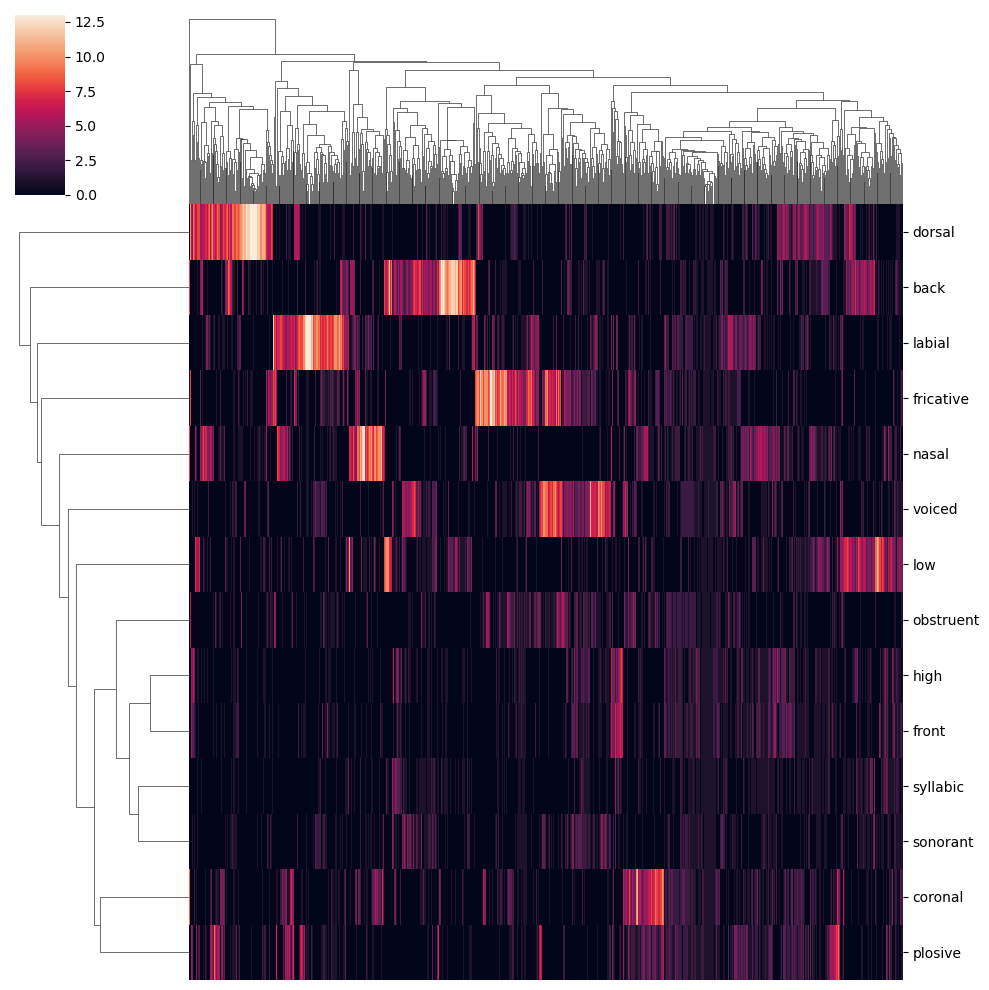

In [164]:
plot_layer = 0
plot_data = feature_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=feature_names, xticklabels=False)

(14, 768)


/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


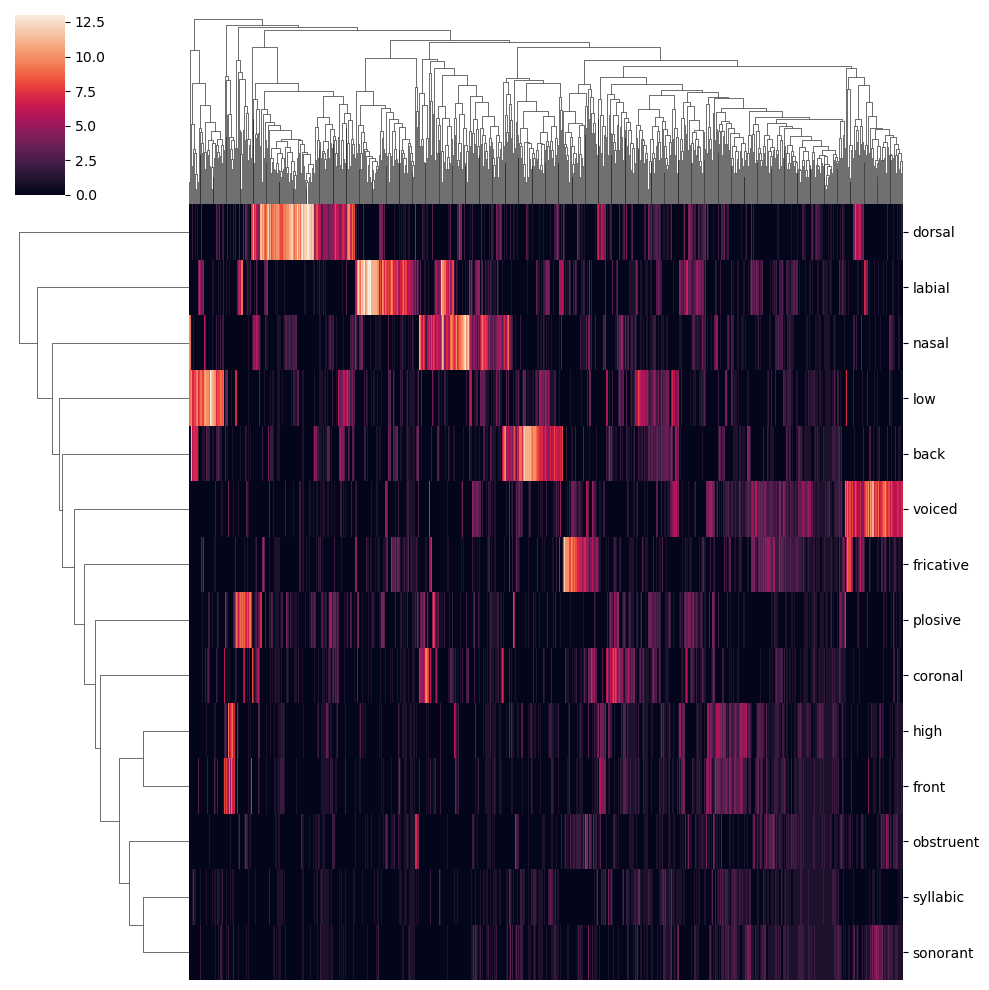

In [165]:
plot_layer = 5
plot_data = feature_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=feature_names, xticklabels=False)

(14, 768)


/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


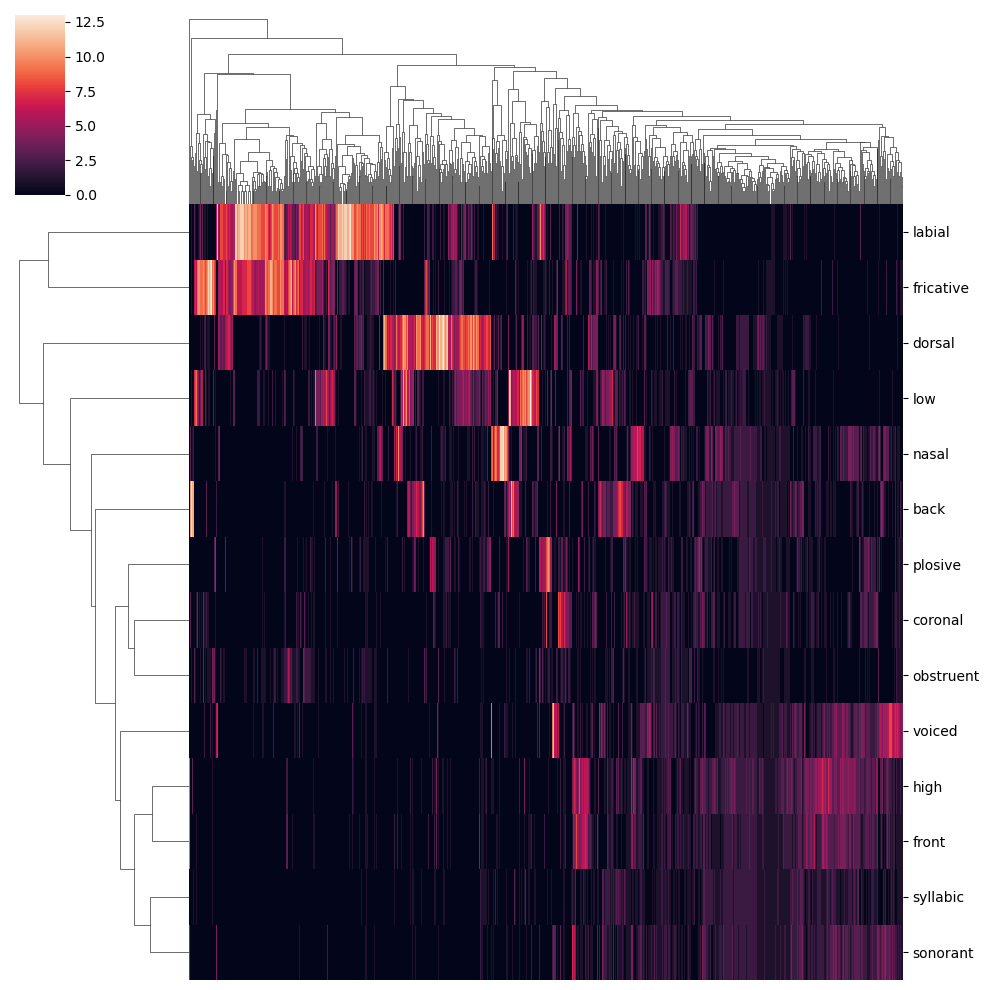

In [166]:
plot_layer = 12
plot_data = feature_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=feature_names, xticklabels=False)

### Phoneme selectivity index

In [171]:
all_phonemes = set()
def update_all_phonemes(item):
    all_phonemes.update(item["phonemic_detail"]["utterance"])
eval_dataset.map(update_all_phonemes)
all_phonemes = sorted(all_phonemes)

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

In [193]:
# DEV
phoneme_eval_layers = [0, 5, 12]

# First characterize the response of each hidden unit to each feature
# as the mean activation of the hidden unit over a 0-60ms time window
# with the onset of the feature.
phoneme_responses = defaultdict(list)
phoneme_response_window = 0.06
phoneme_agg_fn = np.mean

def add_phoneme_responses(item, eval_layers=None, model_sfreq=50):
    if eval_layers is None:
        eval_layers = phoneme_eval_layers[:]

    compression_ratio = (model._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])).item()
    for layer in eval_layers:
        hidden_state = np.array(item[f"hidden_state_{layer}"])
        for start, stop, phoneme in zip(item["phonemic_detail"]["start"], item["phonemic_detail"]["stop"], item["phonemic_detail"]["utterance"]):
            start_frame = int(start * compression_ratio)
            stop_frame = int(stop * compression_ratio)
            stop_frame = int(min(stop_frame, start_frame + phoneme_response_window * model_sfreq, hidden_state.shape[0]))

            phoneme_response = phoneme_agg_fn(hidden_state[start_frame:stop_frame], axis=0)
            if not np.isnan(phoneme_response).any():
                phoneme_responses[layer, phoneme].append(phoneme_response)

eval_dataset.select(range(100)).map(add_phoneme_responses, fn_kwargs={"eval_layers": phoneme_eval_layers})

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

/userdata/jgauthier/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/jgauthier/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'hidden_state_0', 'hidden_state_1', 'hidden_state_2', 'hidden_state_3', 'hidden_state_4', 'hidden_state_5', 'hidden_state_6', 'hidden_state_7', 'hidden_state_8', 'hidden_state_9', 'hidden_state_10', 'hidden_state_11', 'hidden_state_12', 'phn_feat_dorsal', 'phn_feat_coronal', 'phn_feat_labial', 'phn_feat_high', 'phn_feat_front', 'phn_feat_low', 'phn_feat_back', 'phn_feat_plosive', 'phn_feat_fricative', 'phn_feat_syllabic', 'phn_feat_nasal', 'phn_feat_voiced', 'phn_feat_obstruent', 'phn_feat_sonorant', 'phn_feat_names'],
    num_rows: 100
})

In [195]:
# phoneme_responses_mat: num_layers * hidden_size * num_phonemes
phoneme_responses_mat = np.array([[np.array(phoneme_responses[layer, phoneme]).mean(axis=0)
                                   for phoneme in all_phonemes]
                                  for layer in phoneme_eval_layers])
phoneme_responses_mat = phoneme_responses_mat.transpose(0, 2, 1)

In [196]:
phoneme_responses_mat -= phoneme_responses_mat.mean(axis=2, keepdims=True)
phoneme_responses_mat /= phoneme_responses_mat.std(axis=2, keepdims=True)

In [217]:
# For each feature--hidden unit pair, calculate feature selectivity index:
# FSI_ij receives 1 point for every feature to which hidden unit i responds
# more weakly than it did to feature j by a threshold (0.15).
phoneme_selectivity_threshold = 2
phoneme_selectivity = np.zeros_like(phoneme_responses_mat)

for layer_idx in range(phoneme_selectivity.shape[0]):
    for hidden_idx in range(phoneme_selectivity.shape[1]):
        for phoneme_idx in range(phoneme_selectivity.shape[2]):
            phoneme_response = phoneme_responses_mat[layer_idx, hidden_idx, phoneme_idx]

            other_phoneme_responses = np.concatenate([
                phoneme_responses_mat[layer_idx, hidden_idx, :phoneme_idx],
                phoneme_responses_mat[layer_idx, hidden_idx, phoneme_idx + 1:],
            ])
            phoneme_selectivity[layer_idx, hidden_idx, phoneme_idx] = ((phoneme_response - other_phoneme_responses) > phoneme_selectivity_threshold).sum()

(40, 768)


/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


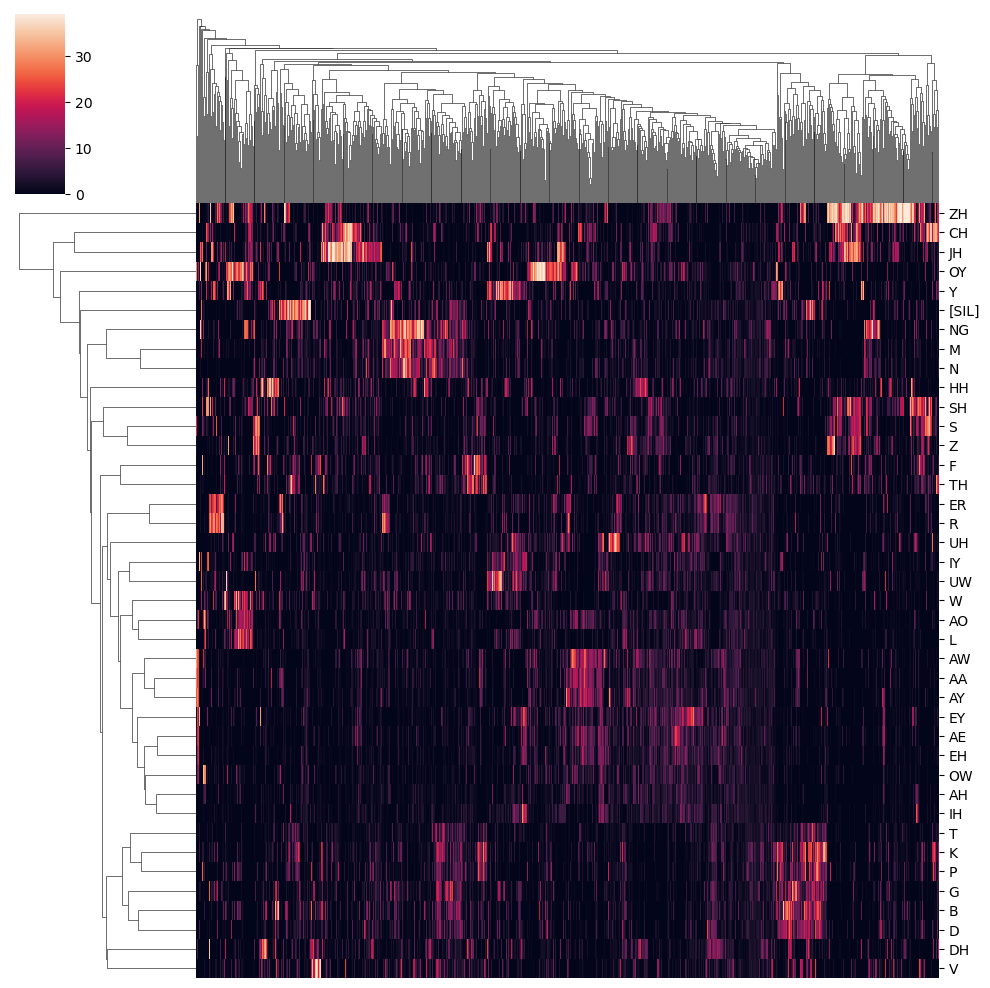

In [218]:
plot_layer = 0
plot_data = phoneme_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=all_phonemes, xticklabels=False)

(40, 768)


/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


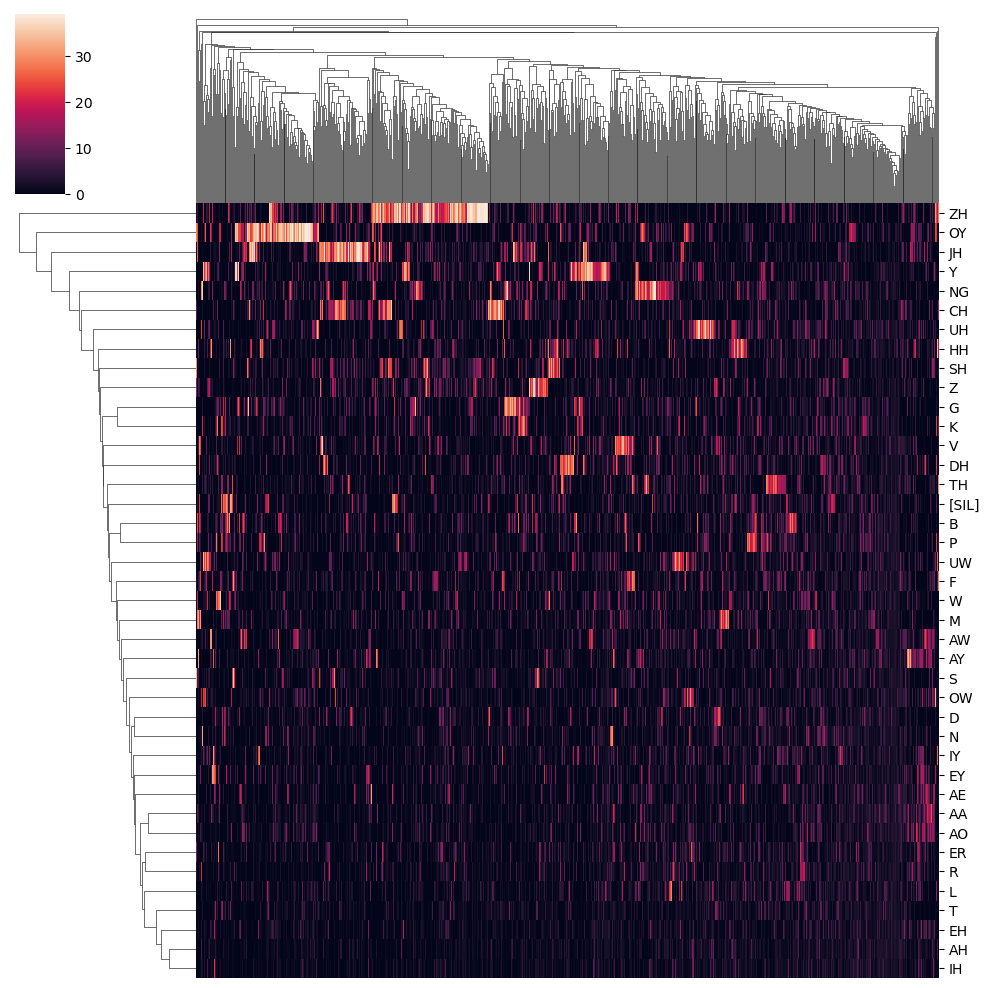

In [219]:
plot_layer = 1
plot_data = phoneme_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=all_phonemes, xticklabels=False)

(40, 768)


/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/userdata/jgauthier/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


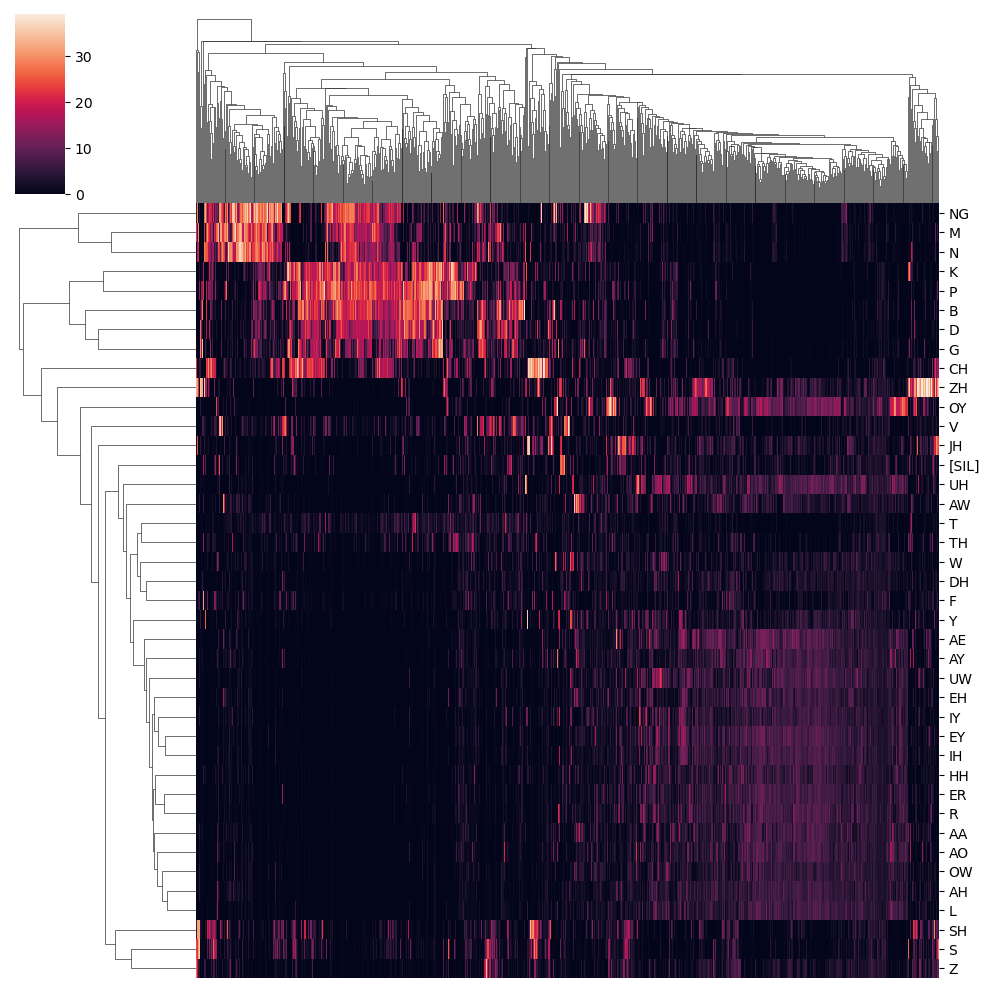

In [220]:
plot_layer = 2
plot_data = phoneme_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=all_phonemes, xticklabels=False)

### Redo this for RNN states

In [228]:
from copy import deepcopy
from src.models.frame_level import FrameLevelLexicalAccess, LexicalAccessDataCollator
from src.models.rnn import ExposedLSTM
from torch.utils.data import DataLoader

model_checkpoint_path = "outputs/outputs_dualhead0.5/models/w2v2_drop6_rnn/checkpoint-5150/"
model: FrameLevelLexicalAccess = FrameLevelLexicalAccess.from_pretrained(model_checkpoint_path)

collator = LexicalAccessDataCollator(
    processor=processor,
    model=model,
    padding=True,
    num_labels=model.config.num_labels,
    regression_target_size=model.config.regressor_target_size,
)

In [222]:
def add_indices(item, idx):
    item["idx"] = idx
    return item
eval_dataset = eval_dataset.map(add_indices, batched=True, batch_size=2000, with_indices=True)

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

In [229]:
rnn_state = deepcopy(model.rnn.state_dict())
exposed_lstm = ExposedLSTM(
    input_size=model.rnn.input_size,
    hidden_size=model.rnn.hidden_size,
    num_layers=model.rnn.num_layers,
    bias=model.rnn.bias,
    batch_first=model.rnn.batch_first,
)
exposed_lstm.load_state_dict(rnn_state)

model.rnn = exposed_lstm
model.config.expose_rnn = True

In [254]:
# Flat representation of all hidden states etc.
flat_idxs = []
rnn_hidden_states = []

dataloader = DataLoader(eval_dataset, batch_size=8,
                        collate_fn=collator, shuffle=False)
for batch in tqdm(dataloader):
    with torch.no_grad():
        batch_output = model(output_hidden_states=True, **batch)

    batch_hidden, batch_cell, batch_input_gate, batch_forget_gate, batch_cell_gate, batch_output_gate = \
        batch_output.rnn_hidden_states
    batch_hidden = batch_hidden.permute(1, 2, 0, 3)
    # batch_cell = batch_cell.permute(1, 2, 0, 3)
    # batch_input_gate = batch_input_gate.permute(1, 2, 0, 3)
    # batch_forget_gate = batch_forget_gate.permute(1, 2, 0, 3)
    # batch_cell_gate = batch_cell_gate.permute(1, 2, 0, 3)
    # batch_output_gate = batch_output_gate.permute(1, 2, 0, 3)

    # we are now in batch * seq_len * num_layers * hidden_size

    real_frames = batch.target_mask.sum(dim=1)
    for i, (idx) in enumerate(batch.idx):
        real_frames_i = real_frames[i]
        flat_idxs.extend([(idx.item(), i) for i in range(real_frames_i)])
        rnn_hidden_states.append(batch_hidden[i, :real_frames_i])
        # cell_states.append(batch_cell[i, :real_frames_i])
        # input_gates.append(batch_input_gate[i, :real_frames_i])
        # forget_gates.append(batch_forget_gate[i, :real_frames_i])
        # cell_gates.append(batch_cell_gate[i, :real_frames_i])
        # output_gates.append(batch_output_gate[i, :real_frames_i])

  0%|          | 0/63 [00:00<?, ?it/s]

Unused kwargs: {'idx': tensor([0, 1, 2, 3, 4, 5, 6, 7])}
Unused kwargs: {'idx': tensor([ 8,  9, 10, 11, 12, 13, 14, 15])}
Unused kwargs: {'idx': tensor([16, 17, 18, 19, 20, 21, 22, 23])}
Unused kwargs: {'idx': tensor([24, 25, 26, 27, 28, 29, 30, 31])}
Unused kwargs: {'idx': tensor([32, 33, 34, 35, 36, 37, 38, 39])}
Unused kwargs: {'idx': tensor([40, 41, 42, 43, 44, 45, 46, 47])}
Unused kwargs: {'idx': tensor([48, 49, 50, 51, 52, 53, 54, 55])}
Unused kwargs: {'idx': tensor([56, 57, 58, 59, 60, 61, 62, 63])}
Unused kwargs: {'idx': tensor([64, 65, 66, 67, 68, 69, 70, 71])}
Unused kwargs: {'idx': tensor([72, 73, 74, 75, 76, 77, 78, 79])}
Unused kwargs: {'idx': tensor([80, 81, 82, 83, 84, 85, 86, 87])}
Unused kwargs: {'idx': tensor([88, 89, 90, 91, 92, 93, 94, 95])}
Unused kwargs: {'idx': tensor([ 96,  97,  98,  99, 100, 101, 102, 103])}
Unused kwargs: {'idx': tensor([104, 105, 106, 107, 108, 109, 110, 111])}
Unused kwargs: {'idx': tensor([112, 113, 114, 115, 116, 117, 118, 119])}
Unused kw

In [255]:
rnn_hidden_states = torch.cat(rnn_hidden_states, dim=0).numpy()
rnn_hidden_states.shape

(50733, 2, 128)

In [256]:
rnn_hidden_state_source_to_flat_idx = {idx: i for i, idx in enumerate(flat_idxs)}

In [257]:
phoneme_eval_layers = [0, 1]

# First characterize the response of each hidden unit to each feature
# as the mean activation of the hidden unit over a 0-60ms time window
# with the onset of the feature.
phoneme_responses = defaultdict(list)
phoneme_response_window = 0.06
phoneme_agg_fn = np.mean

def add_phoneme_responses(item, idx, eval_layers=None, model_sfreq=50):
    if eval_layers is None:
        eval_layers = phoneme_eval_layers[:]

    compression_ratio = (model.encoder._get_feat_extract_output_lengths(len(item["input_values"])) / len(item["input_values"])).item()
    for layer in eval_layers:
        for start, stop, phoneme in zip(item["phonemic_detail"]["start"], item["phonemic_detail"]["stop"], item["phonemic_detail"]["utterance"]):
            start_frame = int(start * compression_ratio)
            stop_frame = int(stop * compression_ratio)
            stop_frame = int(min(stop_frame, start_frame + phoneme_response_window * model_sfreq))

            hidden_state = rnn_hidden_states[rnn_hidden_state_source_to_flat_idx[idx, start_frame] : rnn_hidden_state_source_to_flat_idx[idx, stop_frame],
                                             layer]
            phoneme_response = phoneme_agg_fn(hidden_state, axis=0)
            if not np.isnan(phoneme_response).any():
                phoneme_responses[layer, phoneme].append(phoneme_response)

eval_dataset.map(add_phoneme_responses, with_indices=True, fn_kwargs={"eval_layers": phoneme_eval_layers})

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

/userdata/jgauthier/transformers/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/userdata/jgauthier/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'phonemic_detail', 'word_phonetic_detail', 'word_phonemic_detail', 'input_values', 'phone_targets', 'hidden_state_0', 'hidden_state_1', 'hidden_state_2', 'hidden_state_3', 'hidden_state_4', 'hidden_state_5', 'hidden_state_6', 'hidden_state_7', 'hidden_state_8', 'hidden_state_9', 'hidden_state_10', 'hidden_state_11', 'hidden_state_12', 'phn_feat_dorsal', 'phn_feat_coronal', 'phn_feat_labial', 'phn_feat_high', 'phn_feat_front', 'phn_feat_low', 'phn_feat_back', 'phn_feat_plosive', 'phn_feat_fricative', 'phn_feat_syllabic', 'phn_feat_nasal', 'phn_feat_voiced', 'phn_feat_obstruent', 'phn_feat_sonorant', 'phn_feat_names', 'idx'],
    num_rows: 499
})

In [258]:
# phoneme_responses_mat: num_layers * hidden_size * num_phonemes
phoneme_responses_mat = np.array([[np.array(phoneme_responses[layer, phoneme]).mean(axis=0)
                                   for phoneme in all_phonemes]
                                  for layer in phoneme_eval_layers])
phoneme_responses_mat = phoneme_responses_mat.transpose(0, 2, 1)

In [261]:
phoneme_responses_mat.shape

(2, 128, 40)

In [285]:
# For each feature--hidden unit pair, calculate feature selectivity index:
# FSI_ij receives 1 point for every feature to which hidden unit i responds
# more weakly than it did to feature j by a threshold (0.15).
phoneme_selectivity_threshold = 0.2
phoneme_selectivity = np.zeros_like(phoneme_responses_mat)

for layer_idx in range(phoneme_selectivity.shape[0]):
    for hidden_idx in range(phoneme_selectivity.shape[1]):
        for phoneme_idx in range(phoneme_selectivity.shape[2]):
            phoneme_response = phoneme_responses_mat[layer_idx, hidden_idx, phoneme_idx]

            other_phoneme_responses = np.concatenate([
                phoneme_responses_mat[layer_idx, hidden_idx, :phoneme_idx],
                phoneme_responses_mat[layer_idx, hidden_idx, phoneme_idx + 1:],
            ])
            phoneme_selectivity[layer_idx, hidden_idx, phoneme_idx] = ((phoneme_response - other_phoneme_responses) > phoneme_selectivity_threshold).sum()

(40, 77)


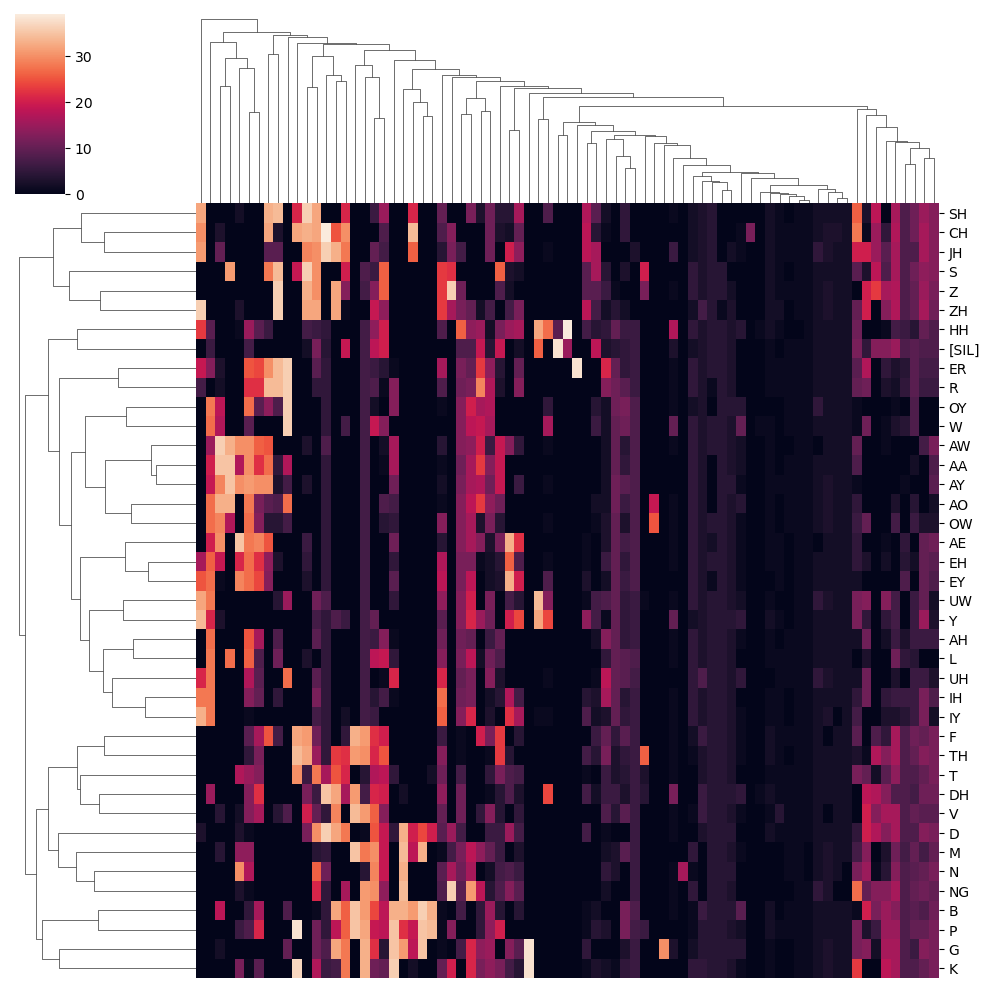

In [286]:
plot_layer = 0
plot_data = phoneme_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=all_phonemes, xticklabels=False)

(40, 84)


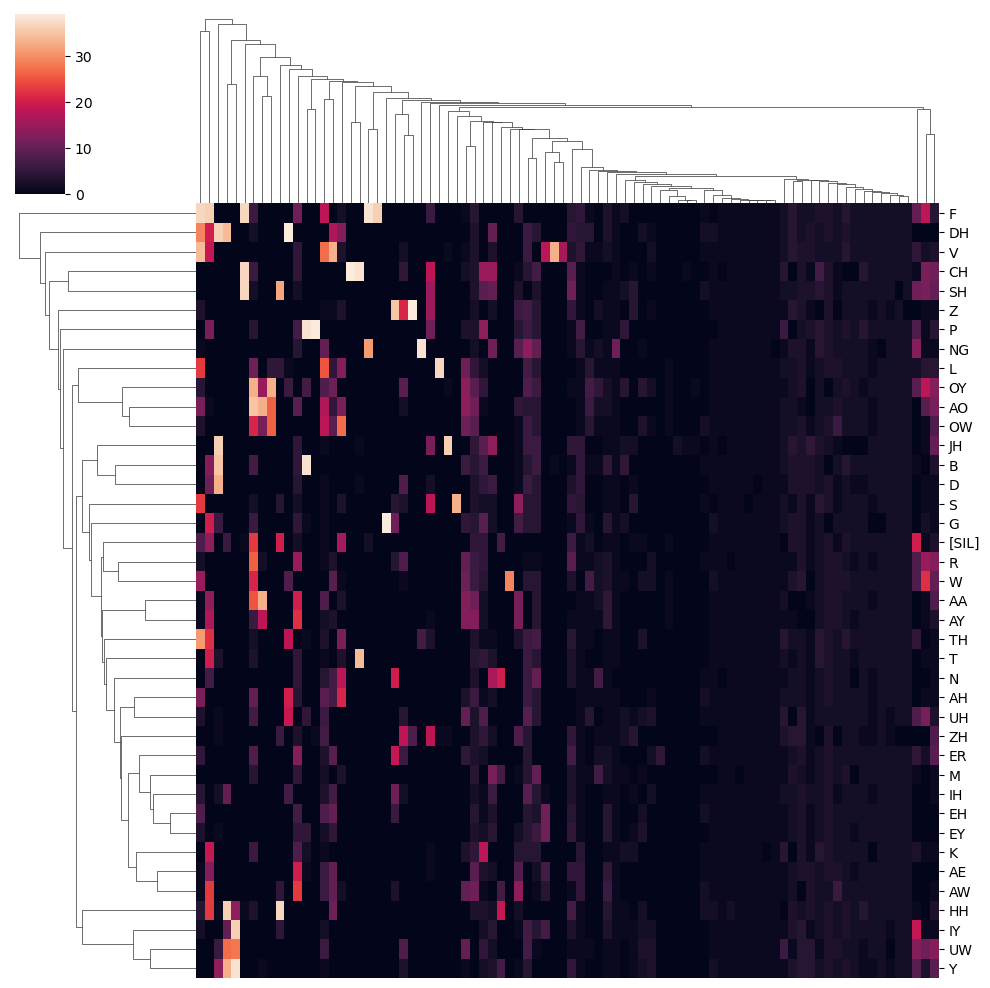

In [287]:
plot_layer = 1
plot_data = phoneme_selectivity[plot_layer].T
plot_data = plot_data[:, plot_data.sum(axis=0) > 0]
print(plot_data.shape)
sns.clustermap(plot_data, yticklabels=all_phonemes, xticklabels=False)